# Navigation Project

## Introduction

The aim of this project is to train an agent in a square world full of bananas, each yellow banana gives a reward of +1 point whereas each blue banana gives a reawrd of -1. An example of the banana world can be seen here:

<img src="banana_collector.gif" width="300" align="center">

The goal of each agent is to collect as many yellow bananas as possible while avoiding the blue bananas.

The state space has 37 dimensions, while the agent has 4 available actions:

- Up
- Down
- Right
- Left

The goal is to solve the environment, in order to solve it, the agent must average a score greater than 13 over 100 consecutive episodes.

## 1. Start the environment

Before training the agent, we need to set the environment and the agent-environment interactions

Loading necessary files

In [1]:
!pip -q install ./python

Creating the environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque 
from agent import Agent
import matplotlib.pyplot as plt

import torch

# Setting the environment with the default brain
env = UnityEnvironment(file_name="data/Banana_Windows_x86_64/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Setting the the deafult brain as the brain (it let the agent decide the actions)

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the state and action spaces

Obtaining state size and action size for the agents to work

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

state = env_info.vector_observations[0]
state_size = len(state)

action_size = brain.vector_action_space_size

## 3. Behavior of untrained agent

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # Reset the environment
state = env_info.vector_observations[0]            # Get the current state
score = 0                                          # Initialize the score

while True:
    action = np.random.randint(action_size)        # Select an action
    env_info = env.step(action)[brain_name]        # Send the action to the environment
    next_state = env_info.vector_observations[0]   # Get the next state
    reward = env_info.rewards[0]                   # Get the reward
    done = env_info.local_done[0]                  # See if episode has finished
    score += reward                                # Update the score
    state = next_state
    if done:
        break 
print("Score: {}".format(score))

Score: 1.0


## 4. Training the agent

For the optimization of the agent, the strategy used was to move a single parameter to optimize in that direction and then moving in other direction to optimize in this new direction, trying to maximize the maximum average score over the last 100 episodes, to this purpose we tried 14 different combinations of hyperparameters with the following combinations:

|   Tau   |  Learning Rate  |   Gamma  |  Update every  | Max Avg Score |
|---------|-----------------|----------|----------------|---------------|
| 0.001   |     0.0005      |   0.9    |        4       |     16.02     |
| 0.001   |     0.0005      |   1.0    |        4       |     16.36     |
| 0.001   |     0.0005      |   0.5    |        4       |      2.81     |
| 0.001   |     0.0005      |   2.0    |        4       |      0.67     |
|**0.001**|   **0.0005**    | **0.99** |     **20**     |   **17.50**   |
| 0.001   |     0.0005      |   0.99   |       40       |     15.29     |
| 0.001   |     0.0005      |   0.99   |       10       |     17.40     |
| 0.01    |     0.0005      |   0.99   |       20       |     15.79     |
| 0.0001  |     0.0005      |   0.99   |       20       |      5.96     |
| 0.002   |     0.0005      |   0.99   |       20       |     17.16     |
| 0.05    |     0.0005      |   0.99   |       20       |      0.26     |
| 0.001   |     0.0001      |   0.99   |       20       |     14.82     |
| 0.001   |     0.001       |   0.99   |       20       |     17.36     |
| 0.01    |     0.01        |   0.99   |       20       |      8.88     |

Is important to note that this method might have reach a local minima which might be different from the global minima.

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Function that let's the agent learn by interacting with the environment, it also prints a moving 
    window with the mean of the last 100 episodes of the agent
    
    Input:
    
        n_episodes  - integer determining the maximum number of training episodes
        max_t       - integer deterimining the maximum number of timesteps per episode
        eps_start   - float with starting value of epsilon, for epsilon-greedy action selection
        eps_end     - float with minimum value of epsilon
        eps_decay   - float with multiplicative factor (per episode) for decreasing epsilon
        
    Output:
    
        scores  - A list of the scores
    """
    scores = []                              # List containing scores from each episode
    scores_window = deque(maxlen=100)        # Last 100 scores
    eps = eps_start                          # Initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # Reset the environment
        state = env_info.vector_observations[0]            # Get the current state
        score = 0   
        
        for t in range(max_t):
            action = agent.act(state, eps)                      # Select an action
            action = int(action)                                # Converting action to int32 (otherwise crashes)
            env_info = env.step(action)[brain_name]             # Send the action to the environment
            next_state = env_info.vector_observations[0]        # Get the next state
            reward = env_info.rewards[0]                        # Get the reward
            done = env_info.local_done[0]                       # See if episode has finished
            agent.step(state, action, reward, next_state, done) # Step and learning process
            score += reward                                     # Update the score
            state = next_state                                  # Roll over the state to next time step
            if done:                                            # Exit loop if episode finished
                break
                
        scores_window.append(score)          # Save most recent score
        scores.append(score)                 # Save most recent score
        eps = max(eps_end, eps_decay*eps)    # Decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

Episode 100	Average Score: 0.05
Episode 200	Average Score: 1.19
Episode 300	Average Score: 3.83
Episode 400	Average Score: 6.47
Episode 500	Average Score: 6.51
Episode 600	Average Score: 6.71
Episode 700	Average Score: 5.46
Episode 800	Average Score: 9.31
Episode 900	Average Score: 9.53
Episode 1000	Average Score: 14.14
Episode 1100	Average Score: 15.16
Episode 1200	Average Score: 14.95
Episode 1300	Average Score: 15.41
Episode 1400	Average Score: 15.71
Episode 1500	Average Score: 16.05
Episode 1600	Average Score: 16.87
Episode 1700	Average Score: 17.19
Episode 1800	Average Score: 16.45
Episode 1900	Average Score: 17.32
Episode 2000	Average Score: 17.14


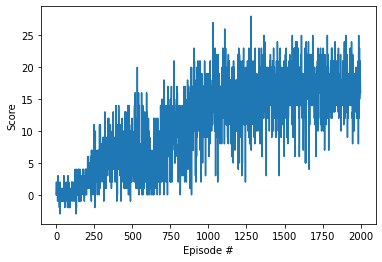

In [8]:
agent = Agent(state_size = state_size, action_size = action_size, seed = 17)
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

From the graph above, we can see that the agent reaches the benchmark of +13 after 1,000 iterations.

Saving agent weights

In [16]:
torch.save(agent.qnetwork_local.state_dict(), 'weights.pth')

## 5. Behavior of trained agent

In [11]:
eps = 0.01

env_info = env.reset(train_mode=False)[brain_name] # Reset the environment
state = env_info.vector_observations[0]            # Get the current state
score = 0                                          # Initialize the score

while True:
    action = agent.act(state, eps)                 # Select an action
    action = int(action)                                # Converting action to int32 (otherwise crashes)
    env_info = env.step(action)[brain_name]        # Send the action to the environment
    next_state = env_info.vector_observations[0]   # Get the next state
    reward = env_info.rewards[0]                   # Get the reward
    done = env_info.local_done[0]                  # See if episode has finished
    score += reward                                # Update the score
    state = next_state
    if done:
        break 
print("Score: {}".format(score))

Score: 16.0


In [12]:
env.close()